# Seismic Velocity Analysis using Clustering

In the development of seismic methods for subsurface exploration, [stacking](https://sepwww.stanford.edu/sep/prof/iei/vdmo/paper_html/node2.html) over offset was once the most important process. Given [common-midpoint (CMP) gather](https://subsurfwiki.org/wiki/Gather) of seismic dataset, stacking refers to the process of summing all the traces with different offsets to one single trace after [normal moveout (NMO)](https://sepwww.stanford.edu/sep/prof/iei/vdmo/paper_html/node3.html) using correct RMS velocity. To get the RMS velocity that can be used for stacking, a [stacking velocity analysis](https://sepwww.stanford.edu/sep/prof/iei/vdmo/paper_html/node4.html) is required.




### CMP gather

When a geophysicist speaks about pre-stack data, they are usually talking about a particular class of gather. A gather is a collection of seismic traces which share some common geometric attribute. Gathers are sorted from field records in order to examine the depedance of amplitude, signal:noise, move-out, frequency content, phase, and other seismic attributes, on offset, incidence angle, azimuth, and other geometric attributes that are important for data processing and imaging.

In CMP gather, traces are sorted by surface geometry to approximate a single reflection point in the earth. Data from several shots and receivers are combined into a single gather. The traces are sorted by offset in order to perform velocity analysis for data processing and hyperbolic moveout correction. Only shot–receiver geometry is required to construct this type of gather.

### Normal moveout (NMO)

Normal moveout correction is a stretching of the time axis to make all seismograms look like zero-offset seismograms. In its simplest form, NMO is based on the Pythagorean relation $t_{NMO}^2 \ =$ $t^2 \,-\, x^2 / v^2$. In a constant velocity earth, the NMO correction would take the asymptote of the hyperbola family and move it up to $t\ =\ 0$. This abandons anything on the time axis before the first arrival, and stretches the remainder of the seismogram. The stretching is most severe near the first arrival, and diminishes at later times. In the NMO example in Figure 1 you will notice the low frequencies caused by the stretch.

NMO correction may be done to common-shot field profiles or to CMP gathers. NMO applied to a field profile makes it resemble a small portion of a zero-offset section. Then geologic structure is prominently exhibited. NMO on a CMP gather is the principal means of determining the earth's velocity-depth function. This is because CMP gathers are insensitive to earth dip.

Figure 1 below shows a CMP gather and its NMOed gather. The vertical axis is seismic record time, and the hrozontal axis is the offset in kilo-meters.


| ![CMP](https://sepwww.stanford.edu/sep/prof/iei/vdmo/Gif/cmpnmo.gif) |
|:--:|
| *Figure 1: CMP gather (left) and the corresponding NMOed gather using correct RMS velocity.* |

### Velocity Analysis

A conventional velocity analysis uses a collection of trial velocities. Each trial velocity is taken to be a constant function of depth and is used to moveout correct the data. Figure 2 (left) exhibits the CMP gather of Figure 1 (left) after moveout correction by a constant velocity. Notice that the events in the middle of the gather are nearly flattened, whereas the early events are undercorrected and later events are overcorrected. This is typical because the amount of moveout correction varies inversely with velocity (by Pythagoras), and the earth's velocity normally increases with depth. A measure of the goodness of fit of the NMO velocity to the earth velocity is found by summing the CDP gather over offset. Presumably, the better the velocities match, the better (bigger) will be the sum. The process is repeated for many velocities. The amplitude of the sum, contoured as a function of time and velocity, is shown in Figure 2 (right).


|![figure2](https://sepwww.stanford.edu/sep/prof/iei/vdmo/Gif/cmphale.gif)|
|:--:|
| *Figure 2: CMP gather NMOed with constanct velocity (left) and the velocity semblance (right) for velocity analysis.* |

In field seismic data processing, it requires tremendous human efforts to analysis all the velocity semblances generated from a large number of CMP gathers. It is nice to think about how to apply machine learning methods to automate this process.



# Assignment

In this assignment, you are given a single CMP gather in `CMP_gather.csv` along with the corresponding true RMS velocity `true_velocity.csv` and velocity semblance `Velocity_semblance_binarized.csv`.



1.   Use clustering methods to conduct stacking velocity analysis on the velocity semblance.
2.   Conduct NMO using your velocity analysis results, and compare it with the NMO using true velocity.

Notes:

*   Choose any clustering methods you want to use.
*   Velocity semblance is already binarized. The original semblance `Velocity_semblance_original.csv` is provided only for reference.
*   An interpolation of the time-velocity pairs is required before using it in NMO.
*   The codes for NMO is provided along with examples.






### Load and plot the data

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

(749, 37)
(749, 2)
(375, 350)
(375, 350)


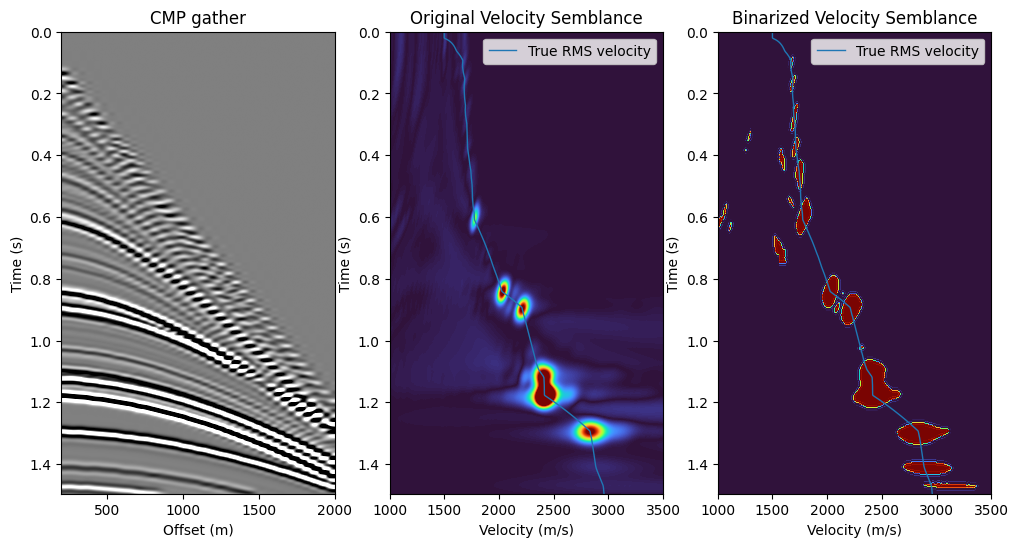

In [5]:
#Load CMP gather
cmp_gather = np.loadtxt("CMP_gather.csv",
                 delimiter=",", dtype=float)
print(cmp_gather.shape)

#Load true RMS velocity
true_vrms = np.loadtxt("true_velocity.csv",
                 delimiter=",", dtype=float)
print(true_vrms.shape)

#Load original Velocity semblance
semblance_ori = np.loadtxt("Velocity_semblance_original.csv",
                delimiter=",", dtype=float)
print(semblance_ori.shape)
sembmin = semblance_ori.min()
sembmax = semblance_ori.max()

#Load digitizied semblance
semblance_dig = np.loadtxt("Velocity_semblance_binarized.csv",
                 delimiter=",", dtype=float)
print(semblance_dig.shape)

#Define some basic parameters
dt=0.002 # time sampling rate: 2ms
nsamples = cmp_gather.shape[0]  #total number of time samples
times = np.arange(0, nsamples*dt, dt)
cmp_interval=50 #Offset interval 50m
offsets=200 + cmp_interval * (np.arange(cmp_gather.shape[1]) )

mintime=0
maxtime=times.max()
minoff=offsets.min()
maxoff=offsets.max()
extent1=(minoff, maxoff, maxtime, mintime)

#Min and max velocity
velmin=1000
velmax=3500
extent2=(velmin, velmax, maxtime, mintime)

# Plot the CMP gather, Velocity Semblance and true RMS velocity
cutoff=0.1
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.2)

# fig = plt.figure(figsize=(3,6))
ax[0].imshow(cmp_gather, extent=extent1, interpolation='lanczos',
             vmin=-cutoff, vmax=cutoff,
           aspect='auto', cmap=plt.cm.binary)
ax[0].set_xlabel('Offset (m)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('CMP gather')
ax[1].imshow(semblance_ori, extent=extent2, interpolation='lanczos',
             vmin=sembmin, vmax=0.3*sembmax,
            aspect='auto', cmap=plt.cm.turbo)
ax[1].plot(true_vrms[:, 1],true_vrms[:, 0], lw=1.0, label="True RMS velocity")
# ax[1].invert_yaxis()
ax[1].set_xlabel('Velocity (m/s)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Original Velocity Semblance')
ax[1].legend()
ax[2].imshow(semblance_dig, extent=extent2, interpolation='lanczos',
             vmin=sembmin, vmax=1.0,
            aspect='auto', cmap=plt.cm.turbo)
ax[2].plot(true_vrms[:, 1],true_vrms[:, 0], lw=1.0, label="True RMS velocity")
# ax[1].invert_yaxis()
ax[2].set_xlabel('Velocity (m/s)')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Binarized Velocity Semblance')
ax[2].legend()

### Codes for normal moveout (NMO)

In this part, the codes that used for NMO is provided. Also the example to conduct NMO for the provided `CMP_gather.csv` dataset is illustrated.

In [6]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.

    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.

    Parameters
    ----------

    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.

    Returns
    -------

    nmo : 2D array
        The NMO corrected gather.

    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

In [7]:
def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.

    Doesn't consider refractions or changes in velocity.

    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.

    Parameters
    ----------

    t0 : float
        The 0-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.

    Returns
    -------

    t : float
        The reflection travel-time.

    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

In [8]:
def sample_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.

    Parameters
    ----------

    trace : 1D array
        Array containing the amplitudes of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval

    Returns
    -------

    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.

    """
    # The floor function will give us the integer
    # right behind a given float.
    # Use it to get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    N = trace.size
    # Use the 4 samples around time to interpolate
    samples = np.arange(before - 1, before + 3)
    if any(samples < 0) or any(samples >= N):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

### Conduct NMO using the defined function

The function `nmo_correction(cmp_gather, dt, offsets, rms_vel)` takes four inputs. The first 3 has been provided. The last one `rms_vel` is a 1D array that has the same number of time samples as the CMP gather (cmp_gather.shape[0]).

In [9]:
#NMO with correct velocity
nmo_gather_true_vel = nmo_correction(cmp_gather, dt, offsets, true_vrms[:, 1]);

#NMO with incorrect higher velocity
nmo_gather_high_vel = nmo_correction(cmp_gather, dt, offsets, true_vrms[:, 1]*1.2);

#NMO with incorrrect lower velocity
nmo_gather_low_vel = nmo_correction(cmp_gather, dt, offsets, true_vrms[:, 1]*0.8);

### Plot the results

With the correct velocity, the events in CMP gather are flatten after NMO, which is better for stacking.

If velocity is not correct, the events will not be flatten. For higher velocity than the correct ones, the events will bend downwards, and for lower velocity the events will bend upwards.

Text(0, 0.5, 'Time (s)')

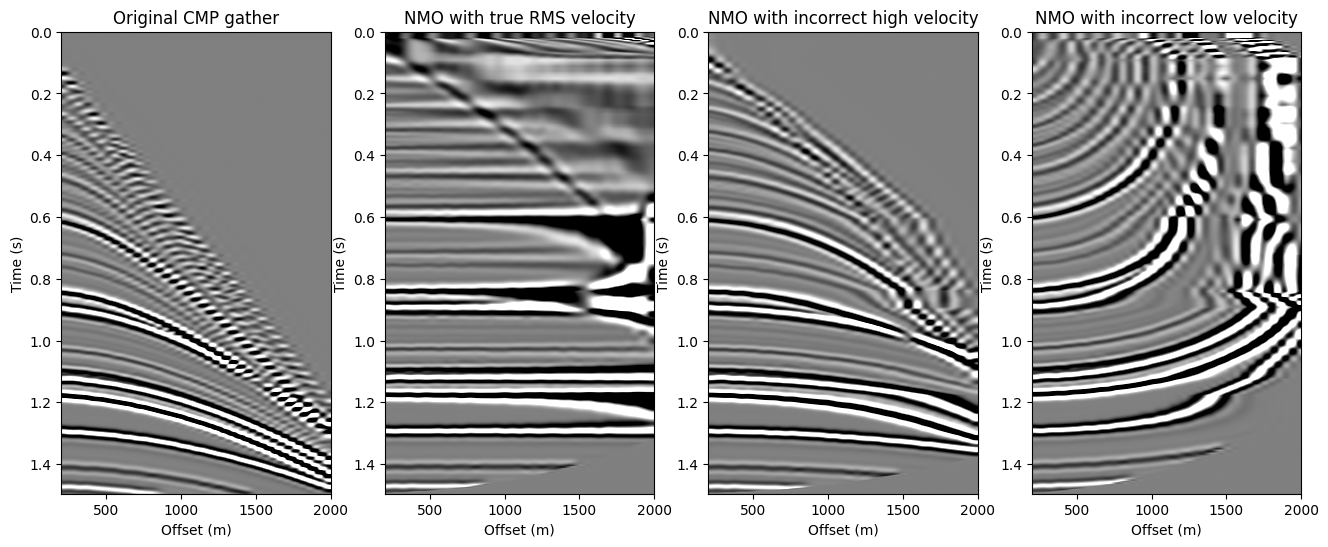

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
ax[0].imshow(cmp_gather, interpolation='lanczos', extent=extent1, vmin=-cutoff, vmax=cutoff,
           aspect='auto', cmap=plt.cm.binary)
ax[0].set_title('Original CMP gather', size=12)
ax[0].set_xlabel('Offset (m)')
ax[0].set_ylabel('Time (s)')
ax[1].imshow(nmo_gather_true_vel, interpolation='lanczos', extent=extent1, vmin=-cutoff, vmax=cutoff,
           aspect='auto', cmap=plt.cm.binary)
ax[1].set_title('NMO with true RMS velocity', size=12);
ax[1].set_xlabel('Offset (m)')
ax[1].set_ylabel('Time (s)')

ax[2].imshow(nmo_gather_high_vel, interpolation='lanczos', extent=extent1, vmin=-cutoff, vmax=cutoff,
           aspect='auto', cmap=plt.cm.binary)
ax[2].set_title('NMO with incorrect high velocity', size=12);
ax[2].set_xlabel('Offset (m)')
ax[2].set_ylabel('Time (s)')

ax[3].imshow(nmo_gather_low_vel, interpolation='lanczos', extent=extent1, vmin=-cutoff, vmax=cutoff,
           aspect='auto', cmap=plt.cm.binary)
ax[3].set_title('NMO with incorrect low velocity', size=12);
ax[3].set_xlabel('Offset (m)')
ax[3].set_ylabel('Time (s)')

### Transform semblance data

In the binarized semblance dataset, there are only 0 and 1 values. The 1 values correpspond to the area of interest where the (time, velocity) pairs should be picked from.

First, we transform the semblance dataset to the form of samples in (time, velocity) for clustering.

In [11]:
dt_semb=0.004   # Time sampling rate for semblance
dv_semb=(3500.-1000.)/semblance_dig.shape[1]  # velocity sampling rate for semblance

# Get the indices where the value of semblance is 1.0
indices = np.argwhere(semblance_dig == 1.0)

# Multiply with time interval and velocity interval to get the tranining data
training_data = np.column_stack( (indices[:, 0] * dt_semb, 1000.0 + indices[:, 1] * dv_semb))
print(training_data)

[[8.40000000e-02 1.67857143e+03]
 [8.80000000e-02 1.67142857e+03]
 [8.80000000e-02 1.67857143e+03]
 ...
 [1.47600000e+00 3.32142857e+03]
 [1.47600000e+00 3.32857143e+03]
 [1.47600000e+00 3.33571429e+03]]


In the training dataset, the first column is travel time in $s$, the second column is RMS velocity in $m/s$.

### Start your coding from here.


# Assignment

In this assignment, you are given a single CMP gather in `CMP_gather.csv` along with the corresponding true RMS velocity `true_velocity.csv` and velocity semblance `Velocity_semblance_binarized.csv`.



1.   Use clustering methods to conduct stacking velocity analysis on the velocity semblance.
2.   Conduct NMO using your velocity analysis results, and compare it with the NMO using true velocity.

Notes:

*   Choose any clustering methods you want to use.
*   Velocity semblance is already binarized. The original semblance `Velocity_semblance_original.csv` is provided only for reference.
*   An interpolation of the time-velocity pairs is required before using it in NMO.
*   The codes for NMO is provided along with examples.






In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the data
velocity_semblance_data = np.loadtxt("Velocity_semblance_binarized.csv", delimiter=",", dtype=float)
true_velocity_data = np.loadtxt("true_velocity.csv", delimiter=",", dtype=float)
cmp_gather_data = np.loadtxt("CMP_gather.csv", delimiter=",", dtype=float)

# Reshape the data for clustering

n_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(velocity_semblance_data)
centroids = kmeans.cluster_centers_
t0 = 0.02

nmo_corrected_data_estimated = np.zeros_like(cmp_gather_data)
offsets=200 + cmp_interval * (np.arange(cmp_gather.shape[1]) )

def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.

    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.

    Parameters
    ----------

    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.

    Returns
    -------

    nmo : 2D array
        The NMO corrected gather.

    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.

    Doesn't consider refractions or changes in velocity.

    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.

    Parameters
    ----------

    t0 : float
        The 0-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.

    Returns
    -------

    t : float
        The reflection travel-time.

    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

def sample_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.

    Parameters
    ----------

    trace : 1D array
        Array containing the amplitudes of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval

    Returns
    -------

    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.

    """
    # The floor function will give us the integer
    # right behind a given float.
    # Use it to get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    N = trace.size
    # Use the 4 samples around time to interpolate
    samples = np.arange(before - 1, before + 3)
    if any(samples < 0) or any(samples >= N):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

nmo_corrected_data_estimated = nmo_correction(cmp_gather_data,t0,offsets, nmo_corrected_data_estimated)
nmo_corrected_data_true= nmo_correction(cmp_gather_data,t0,offsets, true_velocity_data)



C:\Users\hoyou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hoyou\AppData\Local\Temp\ipykernel_11460\2683118015.py:92: RuntimeWarning: divide by zero encountered in divide
  t = np.sqrt(t0**2 + x**2/vnmo**2)


TypeError: only length-1 arrays can be converted to Python scalars